In [1]:
import mne, os
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
J = "20189"

In [6]:
# Read the file logs/error_15590.err
with open(f'logs/error_{J}.err', 'r') as f:
    log = f.read()    

# Extract all the values loss=x.xx, lr= in the log file
losses = [float(x.split('loss=')[1].split(',')[0]) for x in log.split('\n') if 'loss=' in x and '<' in x]
accuracies = [float(x.split('Accuracy=')[1].split(',')[0]) for x in log.split('\n') if 'Accuracy=' in x and '<' in x]
mask_pct = [float(x.split('Mask_pct=')[1].split(',')[0]) for x in log.split('\n') if 'Mask_pct=' in x and '<' in x]

# Extract all the values lr=x.xxe-x] in the log file
lr = np.array([float(x.split('lr=')[1].split(']')[0]) for x in log.split('\n') if 'lr=' in x and '<' in x])

iter = np.array([float(x.split('/')[0].split('| ')[-1]) for x in log.split('\n') if 'Iteration' in x and '<' in x and '%|' in x and 'lr=' in x])

iter_new = [iter[0]]
rollover_sum = 0
for i in range(1, len(iter)):
    if iter[i] < iter[i-1]:  # Detect a rollover
        rollover_sum += iter[i-1]
    iter_new.append(iter[i] + rollover_sum)
    
iter = np.array(iter_new)
del iter_new

In [7]:
# Validation scores

# Read the file logs/output_15590.out
with open(f'logs/output_{J}.out', 'r') as f:
    log = f.read()
    
# Extract all lines what begin with Validation:
val_lines = [x.split('Validation: ')[1] for x in log.split('\n') if 'Validation: ' in x and 'Iteration' in x]

# From each line extract the Accuracy: xx.xx% | and Loss: xx.xx |

val_acc = np.array([float(x.split('Accuracy: ')[1].split('%')[0]) / 100 for x in val_lines])
val_loss = np.array([float(x.split('loss: ')[1].split(' |')[0]) for x in val_lines])

val_iter = np.array([float(x.split("Iteration ")[1].split(' |')[0]) for x in val_lines])
val_iter_new = [val_iter[0]]
rollover_sum = 0
for i in range(1, len(val_iter)):
    if val_iter[i] < val_iter[i-1]:  # Detect a rollover
        rollover_sum += val_iter[i-1]
    val_iter_new.append(val_iter[i] + rollover_sum)
    
val_iter = np.array(val_iter_new)
del val_iter_new

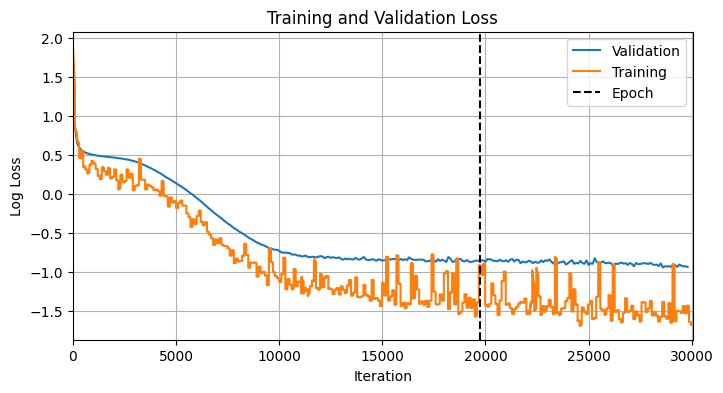

In [8]:
#plt.plot(val_iter, val_acc)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(val_iter, np.log(val_loss), label='Validation')
ax.plot(iter, np.log(losses), label='Training')
ax.set_xlabel('Iteration')
ax.set_ylabel('Log Loss')
ax.set_title('Training and Validation Loss')

# Vline with y = 89700 with label "Epoch"
epoch_iter = 19722 #89760
ax.axvline(epoch_iter, color='k', linestyle='--', label='Epoch')
for epoch in range(2, int(iter.max() / 10000) + 2):
    ax.axvline(epoch_iter * epoch, color='k', linestyle='--')

ax.grid()
ax.legend()
ax.set_xlim(0, iter.max())

plt.show()